# Mapping salt in 2-D seismic image using a deep convolutional neural network
This tutorial describes how to map salt in a 2-D seismic image using a deep convolutional neural network. To follow this tutorial, you won't need any special hardware, software, data or experience - just a Google account.

## Setup ##

1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/seismic_deep_learning/blob/master/tutorial-1/tutorial-1.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. Before running anything in here, you need to tell Colab that would like to use a GPU (important to train our models quickly). This is done by clicking on the ‘Runtime’ tab, selecting ‘Change runtime type’, changing hardware accelerator to ´GPU´ and clicking ´save´. Excellent! Colab is now set up!
6. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
7. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.


## Pre-processing ##
Now that everything is set up, we want to load our data, but first we need to load a couple of useful python packages:


In [179]:
from sys import stdout

import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

from sklearn.metrics import confusion_matrix

Next we clone the Github repository to get our data:

In [151]:
!git clone https://github.com/thilowrona/seismic_deep_learning

fatal: destination path 'seismic_deep_learning' already exists and is not an empty directory.


Now you can load and plot the seismic image and its mask:

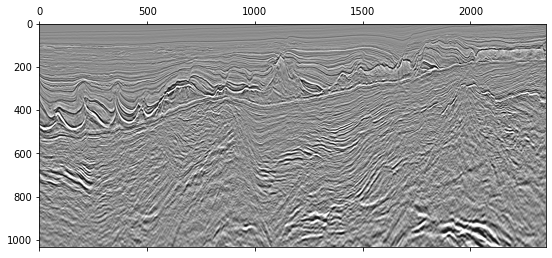

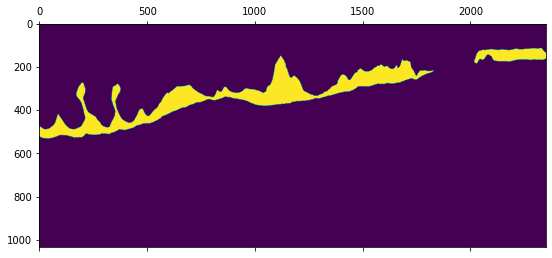

In [152]:
data = mpimg.imread('seismic_deep_learning/tutorial-1/seismic.tif')
data = data[:,:,:1]/255

mask = mpimg.imread('seismic_deep_learning/tutorial-1/mask.tif').copy()
mask = (mask-mask.min())/(mask.max()-mask.min())

plt.matshow(data[:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
plt.matshow(mask, interpolation='spline16', aspect=1)

So now we have one image with a mask, but we need many more examples to train a deep learning model. Of course, we could label more examples, but that takes time and additional data. Let's say we have neither of those. In this case, we can split up our image and mask in to many pairs of small patches. So let's do that:

In [171]:
number_train = 5000                             # Number of training examples
number_val   = 1000                             # Number of validation examples
dim          = (64,64,1)                        # Size of examples


def patchify(data, mask, patch_num, dim):

  X = np.empty((patch_num, *dim))
  y = np.empty((patch_num,2))

  (t_max, x_max, _) = data.shape

  for n in range(patch_num):
      
      # Select random point in data (not at the edge)   
      x_n = random.randint(dim[1]//2,x_max-dim[1]//2)
      t_n = random.randint(dim[0]//2,t_max-dim[0]//2)
      
      # Extract data patch around point   
      X[n,:,:,0] = data[t_n-dim[0]//2:t_n+dim[0]//2,x_n-dim[1]//2:x_n+dim[1]//2,0]
      
      # Note label of point (one-hot-encoding)   
      y[n,0] = mask[t_n,x_n]
      y[n,1] = 1 - mask[t_n,x_n]

  return X, y



X_train, y_train = patchify(data[:,:1200], mask[:,:1200], number_train, dim)
X_val,   y_val   = patchify(data[:,1200:], mask[:,1200:], number_val, dim)

Before training, it's always a good idea to look at the training data, so let's do that:

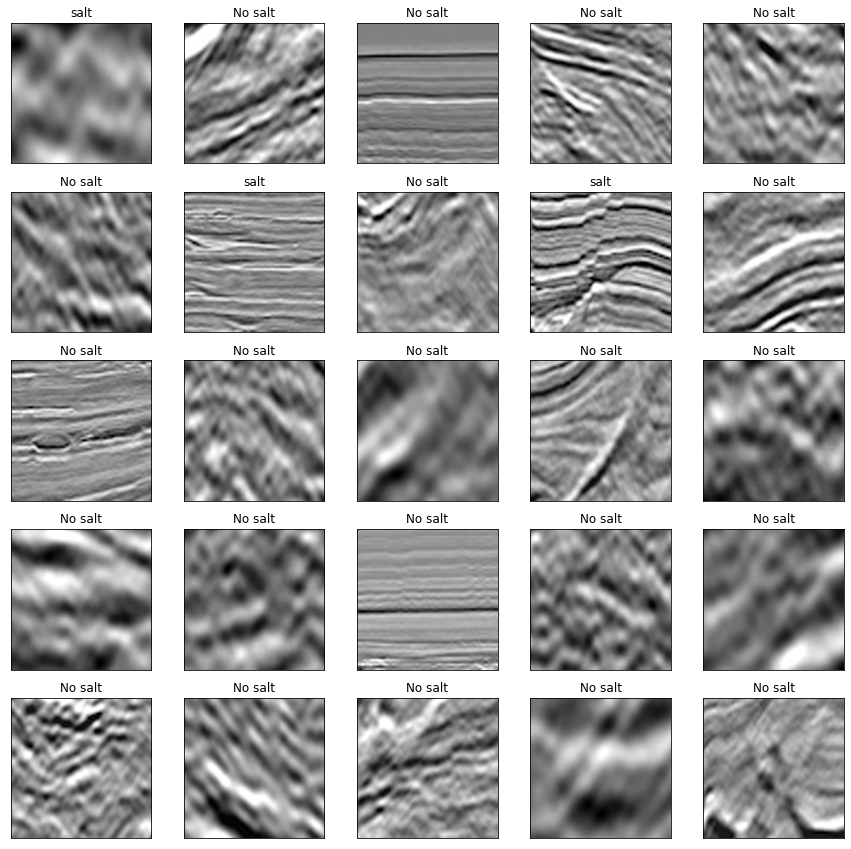

In [172]:
fig, axs = plt.subplots(5, 5, figsize=(15,15))

k = 0
for n in range(5):
  for m in range(5):
    axs[n,m].imshow(X_train[k,:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
    axs[n,m].set_xticks([])
    axs[n,m].set_yticks([])
    k += 1
    if y_train[k,0] == 1:
      axs[n,m].set_title('salt')
    else:
      axs[n,m].set_title('No salt')

What do you notice?

*   Is it an easy task?
*   Could you predict the labels?

Let's see if it will work...



## Training ##
To train our first model, we need to define its architecture. A typical deep convolution neural network for image classification would look something like this:

In [180]:
model = Sequential([Conv2D(16, 3, padding='same', activation='relu', input_shape=dim),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Conv2D(32, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Conv2D(64, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.2),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(2, activation='softmax')])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 16, 16, 64)      

Now you can train your first convolutional neural net:

In [181]:
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=10)

Epoch 1/10
157/157 [==============================] - 1s 7ms/step - loss: 0.2881 - binary_accuracy: 0.9212 - val_loss: 0.2425 - val_binary_accuracy: 0.9550
Epoch 2/10
157/157 [==============================] - 1s 5ms/step - loss: 0.2044 - binary_accuracy: 0.9330 - val_loss: 0.2417 - val_binary_accuracy: 0.9340
Epoch 3/10
157/157 [==============================] - 1s 5ms/step - loss: 0.1797 - binary_accuracy: 0.9422 - val_loss: 0.2342 - val_binary_accuracy: 0.9250
Epoch 4/10
157/157 [==============================] - 1s 5ms/step - loss: 0.1446 - binary_accuracy: 0.9494 - val_loss: 0.2304 - val_binary_accuracy: 0.9160
Epoch 5/10
157/157 [==============================] - 1s 5ms/step - loss: 0.1163 - binary_accuracy: 0.9570 - val_loss: 0.1968 - val_binary_accuracy: 0.9400
Epoch 6/10
157/157 [==============================] - 1s 5ms/step - loss: 0.0949 - binary_accuracy: 0.9654 - val_loss: 0.2354 - val_binary_accuracy: 0.9370
Epoch 7/10
157/157 [==============================] - 1s 5ms/ste

To visualize our training, you can plot learning curves:

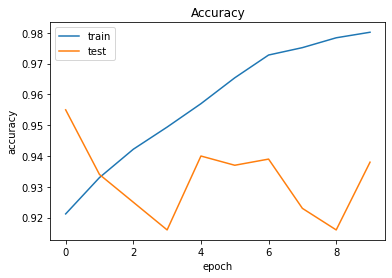

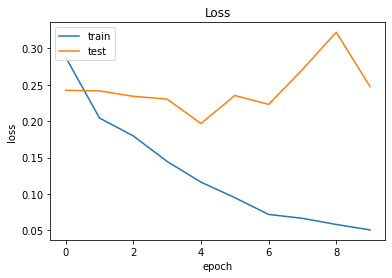

In [182]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

and a confusion matrix:

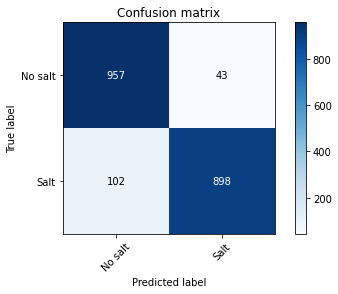

In [183]:
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                    ha="center", va='center',
                    color="white" if cm[i, j] > thresh else "black")



y_true = y_val
y_pred = model.predict(X_val)

cm = confusion_matrix(y_true.astype(int)[:,0], y_pred.astype(int)[:,0]) + np.fliplr(confusion_matrix(y_true.astype(int)[:,1], y_pred.astype(int)[:,1]))
   
plot_confusion_matrix(cm, ['No salt', 'Salt'])

##Application##
Finally, we can apply our model to the entire image to see how well it has learned to recognize salt structures in our seismic image. Because we have to predict the label of each pixel in the image, this takes a while (~4 mins)

99

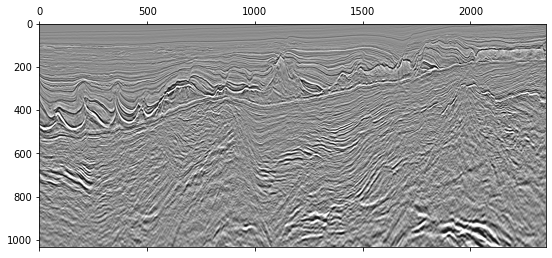

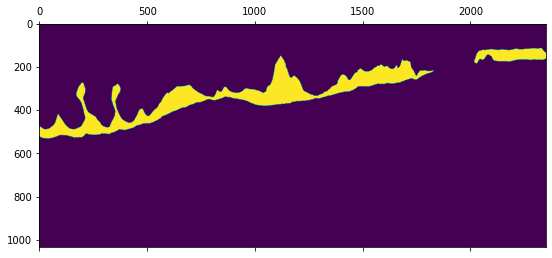

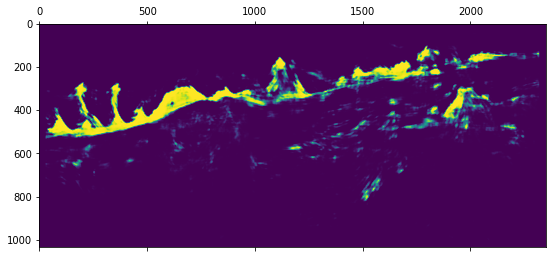

In [187]:
(t_max, x_max, _) = data.shape
result            = np.zeros((t_max,x_max,2))
batch             = np.zeros((t_max-dim[1], *dim))

m = 0
n = 0
for x in range(dim[0]//2,x_max-dim[0]//2): 
  stdout.write("\r%d" % m)
  stdout.flush()
  m = m + 100/(x_max-dim[0])

  for t in range(dim[1]//2,t_max-dim[1]//2):
    batch[n,:,:,0] = data[t-dim[1]//2:t+dim[1]//2, x-dim[0]//2:x+dim[0]//2, 0] 
    n = n + 1

  result[dim[1]//2:t_max-dim[1]//2,x,:] = model.predict_on_batch(batch)
  n = 0

plt.matshow(data[:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
plt.matshow(mask, interpolation='spline16', aspect=1)
plt.matshow(result[:,:,0], interpolation='spline16', aspect=1)
plt.show()


Excellent! Your first model is already able to recognize most of the salt in the seismic section. If you want to know how to improve the prediction in terms of speed and accuracy, check out [tutorial-2](https://github.com/thilowrona/seismic_deep_learning/blob/master/tutorial-2/tutorial_2.ipynb)